# Active Learning
## Names :  Amine FERDJAOUI, Tanguy HERSERANT, Ilyes ZEMALACHE

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from scipy.stats import entropy
from sklearn.utils import Bunch
from sklearn.pipeline import Pipeline
from matplotlib.pyplot import figure
from matplotlib.pyplot import *
from numpy import linspace
from random import sample
import pandas as pd 
import numpy as np

## Import and Explore Data
In this project we used two different datasets. The first one is the following, which is a classic NLP dataset : $ng5$.<br>
The second dataset is downloaded online and will be presented after.

In [2]:
categories = ['rec.motorcycles', 'rec.sport.baseball',
                'comp.graphics', 'sci.space',
                'talk.politics.mideast']
remove = ("headers", "footers", "quotes")
train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [6]:
print("\n".join(train.data[0].split("\n")))


I'd be willing to make two wagers:
1) Snow doesn't win ROY.
2) Mattingly is out of baseball within five years.

I'm skeptical of the first, because I don't think Snow is that good a
player, and he is on a losing team.

I'm skeptical of the second because of his back.  Mattingly is 32 this
year, and how many players play until they are 40?  Not too many, and
most of them didn't have chronic back problems when they were 32.

Could be wrong on either or both, but I think that's the smart way to
bet...


In [7]:
print(train.target_names[train.target[0]])

rec.sport.baseball


### Define classifiers 
We used two classifiers in this project : We used first a simple Naive Bayes Classifier, and then we added an SVM classifier, which we optimised by choosing the right parameters.

In [8]:
## Create a pipeline to make it simpler
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()),
])

In [9]:
## Create a pipeline to make it simpler
text_clf_svm = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', SGDClassifier(loss='log', penalty='l2',
                           alpha=1e-5,random_state=42,
                           max_iter=5, tol=None)),
])

## Define Required Functions
These functions are used in the active learner loop process. 

In [15]:
# Define the function that updates datasets (the seed and unlabeled tables)
def update(seed, unlabeled, ind):
    seed.data = seed.data + [unlabeled.data[i] for i in ind]
    seed.target = np.append(seed.target,unlabeled.target[ind])
    unlabeled.data = [unlabeled.data[i] for i in range(len(unlabeled.data)) if i not in ind]
    unlabeled.target = np.delete(unlabeled.target, ind)
    return seed, unlabeled

In [16]:
# Define the function that trains the model and stores accuracy 
def update_accuracy(seed, unlabeled, train_accuracy, accuracy, classifier):
    global test, train
    # Train the clasifier
    classifier.fit(seed.data, seed.target)
    # predicted classes and corresponding probabilities
    predicted_proba = classifier.predict_proba(unlabeled.data)
    # return accurcy on train data
    predicted = classifier.predict(train.data)
    train_accuracy.append(np.mean(predicted == train.target))  
    # check the real accuracy on test data
    predicted = classifier.predict(test.data)
    accuracy.append(np.mean(predicted == test.target))
    return train_accuracy, accuracy, predicted_proba 

## Start the loop process (Function)
The Active Learner process is defined in a compact function that makes use of the two previous function in order to optimize the code.

In [17]:
def active_learner(train, test, classifier, initial_size, n):

    length = len(train.data)
    seed_uncert = Bunch(data=train.data[0:initial_size], target=train.target[0:initial_size])
    seed_margin = Bunch(data=train.data[0:initial_size], target=train.target[0:initial_size])
    seed_entropy = Bunch(data=train.data[0:initial_size], target=train.target[0:initial_size])
    seed_rand = Bunch(data=train.data[0:initial_size], target=train.target[0:initial_size])
    unlabeled_uncert = Bunch(data=train.data[initial_size:length-1], target=train.target[initial_size:length-1])
    unlabeled_margin = Bunch(data=train.data[initial_size:length-1], target=train.target[initial_size:length-1])
    unlabeled_entropy = Bunch(data=train.data[initial_size:length-1], target=train.target[initial_size:length-1])
    unlabeled_rand = Bunch(data=train.data[initial_size:length-1], target=train.target[initial_size:length-1])

    accuracy_uncert, accuracy_margin, accuracy_entropy, accuracy_rand = [], [], [], []
    t_accuracy_uncert, t_accuracy_margin, t_accuracy_entropy, t_accuracy_rand = [], [], [], []

    
    # Start the loop
    while len(unlabeled_uncert.data) > 0:
        ## Least Confidence (aka. Uncertainty) Strategy
        t_accuracy_uncert, accuracy_uncert, predicted_proba = update_accuracy(seed_uncert, unlabeled_uncert, t_accuracy_uncert, accuracy_uncert, classifier)
        uncertainty = 1 - predicted_proba.max(axis=1)
        ## Margin Sampling
        t_accuracy_margin, accuracy_margin, predicted_proba = update_accuracy(seed_margin, unlabeled_margin, t_accuracy_margin, accuracy_margin, classifier)
        part = np.partition(-predicted_proba, 1, axis=1)
        margin = - part[:, 0] + part[:, 1]
        ## Entropy based
        t_accuracy_entropy, accuracy_entropy, predicted_proba = update_accuracy(seed_entropy, unlabeled_entropy, t_accuracy_entropy, accuracy_entropy, classifier)
        entr = entropy(predicted_proba.T)
        ## Random
        t_accuracy_rand, accuracy_rand, predicted_proba = update_accuracy(seed_rand, unlabeled_rand, t_accuracy_rand, accuracy_rand, classifier)

        if len(unlabeled_uncert.data) > n : 
            # index of top n uncertainty score
            ind_uncert = np.argpartition(uncertainty, -n)[-n:]
            # index of n min margin score
            ind_margin = np.argpartition(margin, n)[:n]
            # index of top n entropy score
            ind_entropy = np.argpartition(entr, -n)[-n:]
            # ind random
            ind_rand = sample([i for i in range(len(unlabeled_rand.data)-1)], n)

            seed_uncert, unlabeled_uncert = update(seed_uncert, unlabeled_uncert, ind_uncert)
            seed_margin, unlabeled_margin = update(seed_margin, unlabeled_margin, ind_margin)
            seed_entropy, unlabeled_entropy = update(seed_entropy, unlabeled_entropy, ind_entropy)
            seed_rand, unlabeled_rand = update(seed_rand, unlabeled_rand, ind_rand)
        else :
            # seed.data = seed.data + unlabeled.data
            # seed.target = np.append(seed.target, unlabeled.target)
            # text_clf.fit(seed.data, seed.target)
            unlabeled_uncert.data = unlabeled_margin = unlabeled_entropy = unlabeled_rand = []
    return t_accuracy_uncert, accuracy_uncert, t_accuracy_margin, accuracy_margin, t_accuracy_entropy, accuracy_entropy, t_accuracy_rand, accuracy_rand

## Test the Learner
Now that we are all set, we will test the Active Learner on our dataset ($ng5$) and get the accuracy with a validation (test) set.<br>
The scores are stored in four different lists following the three strategies that an active learner can take : $Uncertainty$, $Margin$, $entropy$, and in addition to that we added a random method for comparison. We stored also the accuracy scores applied on training set.<br>
The tests are the same for the svm classifier. The results are then compared.

In [18]:
t_accuracy_uncert, accuracy_uncert, t_accuracy_margin, accuracy_margin, t_accuracy_entropy, accuracy_entropy, t_accuracy_rand, accuracy_rand = active_learner(train, test, text_clf, 200, 20)

In [20]:
t_accuracy_uncert_svm, accuracy_uncert_svm, t_accuracy_margin_svm, accuracy_margin_svm, t_accuracy_entropy_svm, accuracy_entropy_svm, t_accuracy_rand_svm, accuracy_rand_svm = active_learner(train, test, text_clf_svm, 200, 20)

Since the lenght of the test entries are around 4300 samples, we chose to start with 200 samples, and for each iteration we label 20 chosen entries.

## Plot and Discuss Results 

Here we proceed to the analysis of results of our methods with some graphs. For each classifier we plot two graphs corresponding to the accuracy obteined on the training set first, and then with the validation (test) set, and we do that according to the different data sizes used during training.<br>
We should also note that all results have been tested many times with multiple parameters in order to find the best parameter for each method.

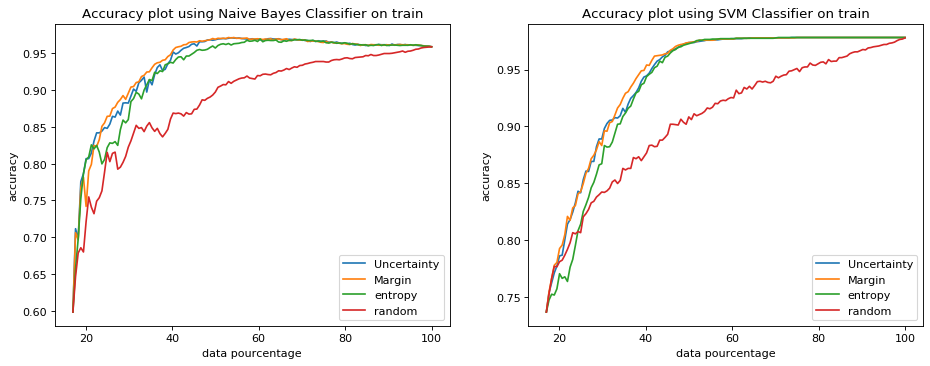

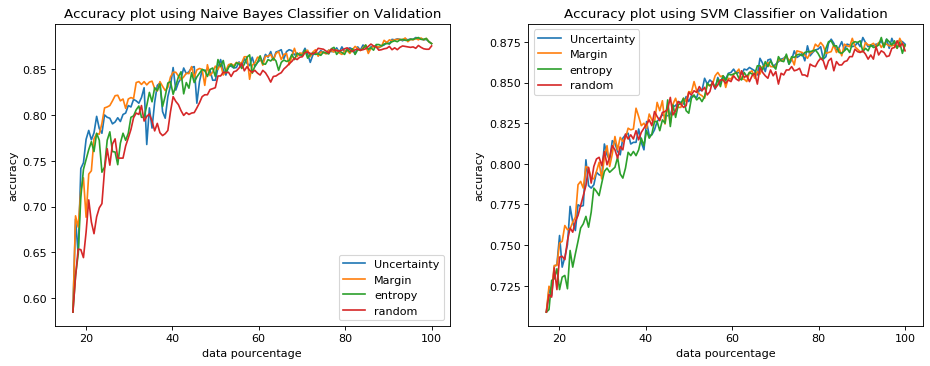

In [23]:
figure(num=None, figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')
x = linspace(500, len(train.data), len(t_accuracy_uncert))

subplot(1, 2, 1)
plot(x/len(train.data)*100, t_accuracy_uncert)
plot(x/len(train.data)*100, t_accuracy_margin)
plot(x/len(train.data)*100, t_accuracy_entropy)
plot(x/len(train.data)*100, t_accuracy_rand)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])

title('Accuracy plot using Naive Bayes Classifier on train')

## Plot accuracy plot using SVM Classifier

subplot(1, 2, 2)
plot(x/len(train.data)*100, t_accuracy_uncert_svm)
plot(x/len(train.data)*100, t_accuracy_margin_svm)
plot(x/len(train.data)*100, t_accuracy_entropy_svm)
plot(x/len(train.data)*100, t_accuracy_rand_svm)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])

title('Accuracy plot using SVM Classifier on train')

show()

figure(num=None, figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')
x = linspace(500, len(train.data), len(accuracy_uncert))

subplot(1, 2, 1)
plot(x/len(train.data)*100, accuracy_uncert)
plot(x/len(train.data)*100, accuracy_margin)
plot(x/len(train.data)*100, accuracy_entropy)
plot(x/len(train.data)*100, accuracy_rand)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])

title('Accuracy plot using Naive Bayes Classifier on Validation')

## Plot accuracy plot using SVM Classifier

subplot(1, 2, 2)
plot(x/len(train.data)*100, accuracy_uncert_svm)
plot(x/len(train.data)*100, accuracy_margin_svm)
plot(x/len(train.data)*100, accuracy_entropy_svm)
plot(x/len(train.data)*100, accuracy_rand_svm)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])

title('Accuracy plot using SVM Classifier on Validation')

show()

### Naive Bayes
From the results above, we can see that the Naive Bayes classifier managed to learn the training set and with only 45% of the data, and keeps plateau after that which proves that the active learner chose the right data to learn from. On the other hand, we see the random pick method that keeps rising and can't stabilize.<br>

Regarding the validation set, we see that even if there exists a little gap between the active learner and the random method, the difference between them is not remarkable.

### SVM
From the graphs above we see that the training results are very similar to the Naive Bayes classifier, where the active learner's three methods achieved about 98% accuracy with only 45% of the data, while the random pick can't stabilize and keep rising.

Concerning the second plot which shows results using the validation set, we see that it gives very good results at the beginning compared to the Naive Bayes, but struggles after that to stabilize and that's what cause the algorithm to give very simillar results compared to a random pick. Thus in this case the active learner didn't add much benefit.

# Import and Explore the second Dataset

The second dataset we used is very similar to $ng5$. It is available in kaggle following the link : 
https://www.kaggle.com/himselfthedecker/facens-nlp-corpus-categorias-treino <br>
It contains santenses in english with a corresponding category for each one.

In [24]:
data = pd.read_csv("corpus_categorias_treino.csv", sep=',', engine='python')
data = data[['words','category']]
data = data.sample(frac=1)
data.head()

,words,category
7602,The books and records with respect to each pro...,government
881,`` I won't even try to thank you '' .,adventure
7431,This system is divided into a forest highway s...,government
3110,The jungle did not retort .,adventure
2070,There was a blur just under my focus of vision...,adventure


In [26]:
data['category'].value_counts()

adventure          3692
government         2391
religion           1375
science_fiction     742
Name: category, dtype: int64

## Split Dataset
Since the dataset downloaded is not split, so we have to split it into training and test data.<br>
We choose 80% of the data for training and the rest for validation (test).<br>

We remarked that categories were ordered, so we have to shuffle them a bit.

In [27]:
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
train = Bunch(data= train.words.values.tolist(), target=train.category.values)
test = data[~msk]
test = Bunch(data= test.words.values.tolist(), target=test.category.values)

## Launch the Model 
We apply the same process used previously.<br>
Since this time the dataset is larger (around 6000), we choose to start with 500 samples, and then we label 40 samples chosen by learner for each iteration. 

In [28]:
t_accuracy_uncert, accuracy_uncert, t_accuracy_margin, accuracy_margin, t_accuracy_entropy, accuracy_entropy, t_accuracy_rand, accuracy_rand = active_learner(train, test, text_clf, 500, 40)
t_accuracy_uncert_svm, accuracy_uncert_svm, t_accuracy_margin_svm, accuracy_margin_svm, t_accuracy_entropy_svm, accuracy_entropy_svm, t_accuracy_rand_svm, accuracy_rand_svm = active_learner(train, test, text_clf_svm, 500, 40)

## Plot and Discuss Results 

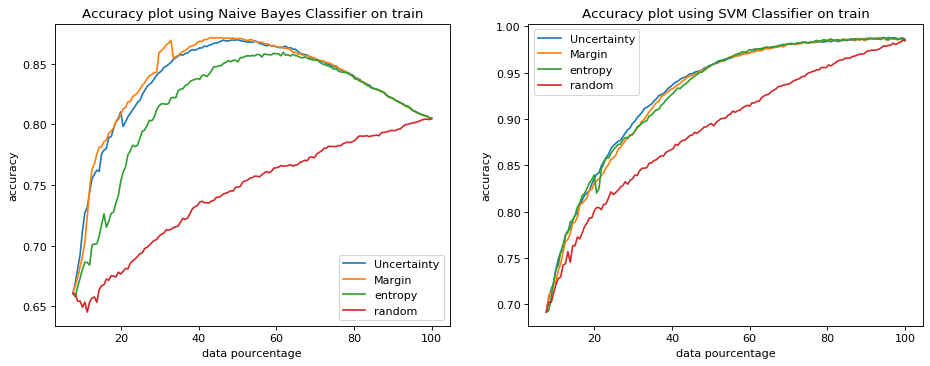

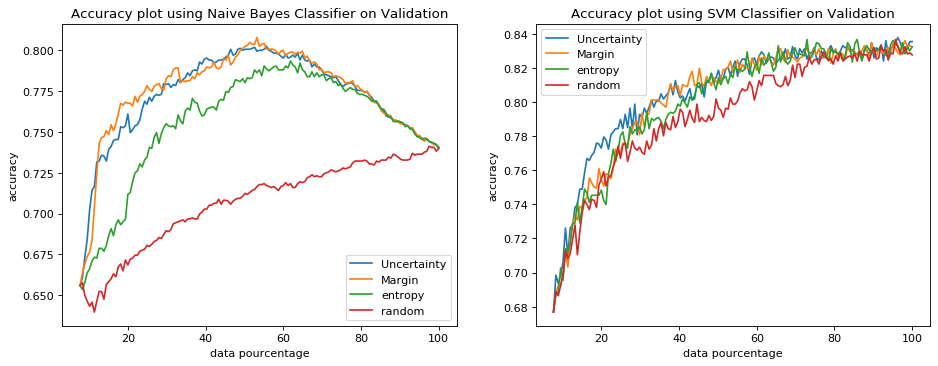

In [29]:
figure(num=None, figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')
x = linspace(500, len(train.data), len(t_accuracy_uncert))

subplot(1, 2, 1)
plot(x/len(train.data)*100, t_accuracy_uncert)
plot(x/len(train.data)*100, t_accuracy_margin)
plot(x/len(train.data)*100, t_accuracy_entropy)
plot(x/len(train.data)*100, t_accuracy_rand)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])

title('Accuracy plot using Naive Bayes Classifier on train')

## Plot accuracy plot using SVM Classifier

subplot(1, 2, 2)
plot(x/len(train.data)*100, t_accuracy_uncert_svm)
plot(x/len(train.data)*100, t_accuracy_margin_svm)
plot(x/len(train.data)*100, t_accuracy_entropy_svm)
plot(x/len(train.data)*100, t_accuracy_rand_svm)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])

title('Accuracy plot using SVM Classifier on train')

show()

figure(num=None, figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')
x = linspace(500, len(train.data), len(accuracy_uncert))

subplot(1, 2, 1)
plot(x/len(train.data)*100, accuracy_uncert)
plot(x/len(train.data)*100, accuracy_margin)
plot(x/len(train.data)*100, accuracy_entropy)
plot(x/len(train.data)*100, accuracy_rand)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])

title('Accuracy plot using Naive Bayes Classifier on Validation')

## Plot accuracy plot using SVM Classifier

subplot(1, 2, 2)
plot(x/len(train.data)*100, accuracy_uncert_svm)
plot(x/len(train.data)*100, accuracy_margin_svm)
plot(x/len(train.data)*100, accuracy_entropy_svm)
plot(x/len(train.data)*100, accuracy_rand_svm)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])

title('Accuracy plot using SVM Classifier on Validation')

show()

### Naive Bayes
We proceed the same way as the ng5 dataset. This time when using the naive bayes classifier we remark a big gap between the random pick and the active learner methods, and that for both training and test datasets. The overfeeting at the end of the three methods shows the good performances of the learner. Why is that ? We see that in the beginning of the training the learner chooses the right points to learn with, and by 50% of the dataset the learner starts to overfit showing that it already chose all the right points and now it starts to overfit, and that's where we need to stop our training.<br>

We remark also that for both the training and validation sets, the margin and uncertainty strategies perform better than the entropy.

### SVM
If we compare the previous results to the SVM classifier, we can see that the SVM performs differently. With the training set the active learner performs better than random, and by 55% of the data it starts to settle unlike the random pick method that keeps rising and can't stabilize.<br>

The performenses with the validation set are close to the training results, we see a little gap between the three active learner's methods and the random pick, since the learner starts to settle with 55 to 60% of the data, versus 75% with random.<br>

In comparison with the Bayes Naive we see that the SVM learns slowly but at the end it gives better performances.  In our case it does't help a lot, because the goal of our active learner is to speed-up the learning rate.<br>

## Final Conclusion

From all results presented above, we constate that the results depend a lot on the dataset and the classifier used.<br>

We saw that the Naive Bayes classifier learns much faster which is a good, since we need to identify only the relevent samples to use for training. But when the data size starts growing the SVM outperforms the Naive Bayes and gives better accuracy.<br>

Regarding the strategies of the active learner, we saw that the results fluctuate a lot. But generally speaking the Margin and Uncertainty strategies gave better results. 